In [1]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df= pd.read_csv("data\\BBC News Train.csv")
test_df = pd.read_csv("data\\BBC News Test.csv")
data=pd.concat([train_df[['ArticleId','Text']], test_df[['ArticleId','Text']]])
train_df.head()
categories=list(set(train_df['Category'].values))

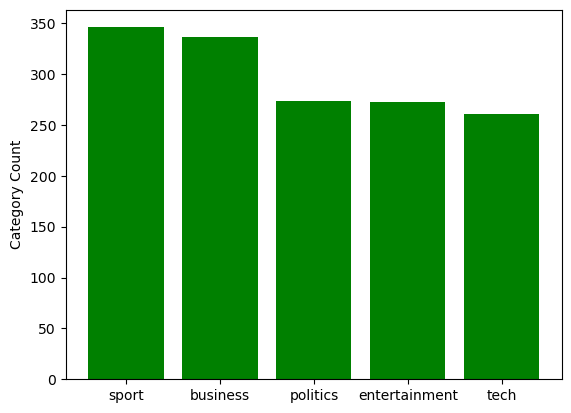

In [3]:
#check count of each category in data
counts = train_df["Category"].value_counts()
plt.bar(counts.index, counts.values,color='green')
plt.ylabel("Category Count")
plt.show()

## Class distribution in data
To analyze data we first need to analyze  whether our data in balanced or imbalanced. To do this we plotted no. of instances of each class and it is clear from the plot above that our data in not imbalanced.We have around 350 news articles about topic 'sport'  with most no. of instances in data. The class with least no. of instances is 'tech' with more than 250 news articles. So our data is not imbalanced.

In [4]:
#check missing values in data
missing_count_tr=train_df.isnull().sum()
print("Missing values in training data")
print(missing_count_tr)
print('*'*10)
missing_count=test_df.isnull().sum()
print("Missing values in test data")
print(missing_count)
print('*'*10)

Missing values in training data
ArticleId    0
Text         0
Category     0
dtype: int64
**********
Missing values in test data
ArticleId    0
Text         0
dtype: int64
**********


## Missing value detection
The next step in data analysis is checking whether there are any missing values in the data or not. We checked the missing values in every column in the dataset and there are no missing values in the data.

<br>
Since or data is balanced with no missing values so we will continue preprocessing the data. Our data is text based and we need to tokenize and clean it first before applying any term weighting techniques on it.

In [5]:
def make_tokens(news):
    stp_wrds=stopwords.words('english')
    words=(word_tokenize(news))
    words= [w.lower() for w in words ]
    words = [w for w in words if w not in stp_wrds and w.isalpha()]
    lemma = WordNetLemmatizer()
    words=[lemma.lemmatize(t) for t in words]
    return words


In [6]:
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    
    #Transform categorical data to numeric
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    label_transformed=le.fit_transform(ytdf)

    # Generate all possible permutation of 0,1,2,3,4 labels
    from itertools import permutations
    n=len(set(yp))
    labels=[i for i in range(n)]
    label_perms=list(permutations(labels, n))

    #Store original indices
    original_indicies=[]
    for i in labels:
        original_indicies.append(np.where(yp==i)[0])

    #Calculate max accuracy
    max_acc=0
    best_perm=None
    for label_perm in label_perms:
        yp_temp=yp.copy()
        for i in range(len(label_perm)):
            yp_temp[original_indicies[i]]=label_perm[i]
    
        acc=accuracy_score(label_transformed,yp_temp)
        if(acc>max_acc):
            max_acc=acc
            best_perm=label_perm
    return best_perm,max_acc
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


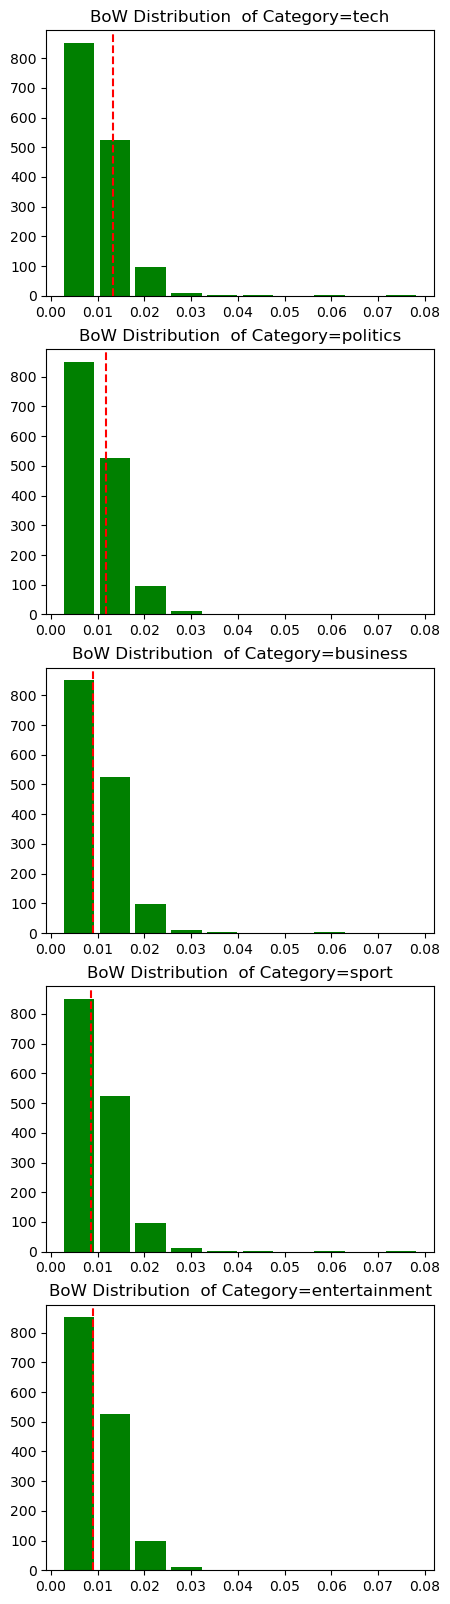

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#BoW Analysis
vectorizer=CountVectorizer(tokenizer=make_tokens).fit(data[['Text']])
train_data_BoW=vectorizer.fit_transform(train_df[['Text']].values[:,0]).todense()
test_data_BoW=vectorizer.fit_transform(test_df[['Text']].values[:,0]).todense()

mean=np.nanmean(train_data_BoW,axis=1)
categories=list(set(train_df['Category'].values))
fig, ax = plt.subplots(len(categories), 1, figsize=(5, 20))
for i,cat in enumerate(categories):
    p=ax[i]
    vals=np.where(train_df[['Category']]==cat)[0]
    cat1=mean[vals,:]
    p.hist(mean, bins=10, rwidth=0.85, color='green')
    p.axvline(x=cat1.mean(), color='red', linestyle='--')
    p.tick_params(labelbottom=True)
    p.set_title(f"BoW Distribution  of Category={cat}")
plt.show()


## Bag of words weighting
We tokenized our data in words and applied preprocessing steps on those tokens. We removed the stop-words from token, removed tokens which are not English words, apply stemming on those tokens.
After preprocessing bag of words weighting techniques was applied on those tokens. In this technique terms and documents was converted to matrix of number where rows of the matrix represent documents in the dataset and column represent terms. Each cell(i,j) in the matrix is no. of instances of term j in document i.
After BoW conversion we analyzed the category wise distribution of values of BoW in dataset and distribution of all classes is almost similar.

In [8]:
#Prediction using Bag of words
train_data_BoW = np.asarray(train_data_BoW)
nmf = NMF(n_components=len(categories))
nmf_pred = nmf.fit_transform(train_data_BoW)
print(nmf_pred.shape)
predictions = np.argmax(nmf_pred, axis=1)
predictions
best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions,n=5)
print("accuracy with NMF is",max_acc )

(1490, 5)
accuracy with NMF is 0.6718120805369128


In [9]:
#BoW Parameter tunning 
parameters =list(range(3,8))
best_acc=0.0
best_p=-1
for p in parameters:
    nmf = NMF(n_components=p)
    nmf_pred = nmf.fit_transform(train_data_BoW)
    predictions = np.argmax(nmf_pred, axis=1)
    best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions)
    if max_acc>best_acc:
        best_acc=max_acc
        best_p=p
print("Best n_components value is",best_p)
print("Best Accuracy value is",best_acc)
    


Best n_components value is 6
Best Accuracy value is 0.7134228187919464


## Non-negative Matrix Factorization (Using BoW)
NMF was applied on BoW matrix with no. of components equal to no. of unique categories in dataset. The accuracy of NMF with Bow is 0.6718120805369128

## Parameter Tunning
To find the NMF parameters with best performance we created list of values for  no. of components. The list of these values are from  3-7 and we get best accuracy value  0.7134228187919464 with no. of components = 6. 


(1490, 20476)


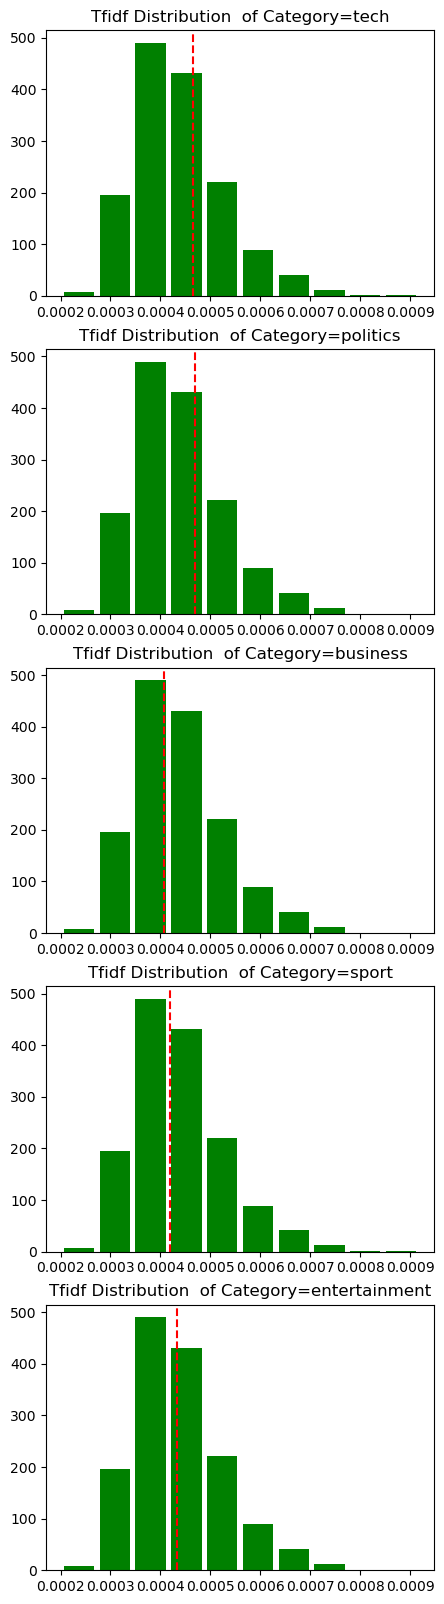

In [10]:
#print mean tfidf of each category in train data
vectorizer=TfidfVectorizer(tokenizer=make_tokens).fit(data[['Text']])
train_data_transfromed=vectorizer.fit_transform(train_df[['Text']].values[:,0]).todense()
test_data_transfromed=vectorizer.fit_transform(test_df[['Text']].values[:,0]).todense()
print(train_data_transfromed.shape)
mean=np.nanmean(train_data_transfromed,axis=1)
categories=list(set(train_df['Category'].values))
fig, ax = plt.subplots(len(categories), 1, figsize=(5, 20))
for i,cat in enumerate(categories):
    p=ax[i]
    vals=np.where(train_df[['Category']]==cat)[0]
    cat1=mean[vals,:]
    p.hist(mean, bins=10, rwidth=0.85, color='green')
    p.axvline(x=cat1.mean(), color='red', linestyle='--')
    p.tick_params(labelbottom=True)
    p.set_title(f"Tfidf Distribution  of Category={cat}")
plt.show()


In [11]:
nmf =  NMF(n_components=len(categories))
nmf_pred = nmf.fit_transform(np.asarray(train_data_transfromed))
predictions = np.argmax(nmf_pred, axis=1)
best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions,n=5)
print("accuracy with NMF is",max_acc )

accuracy with NMF is 0.9167785234899329


In [12]:
#Tfidf Parameter tunning 
train_data_transfromed = np.asarray(train_data_transfromed)
parameters =list(range(3,8))
best_acc=0.0
best_p=-1
for p in parameters:
    nmf = NMF(n_components=p)
    nmf_pred = nmf.fit_transform(train_data_transfromed)
    predictions = np.argmax(nmf_pred, axis=1)
    best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions)
    if max_acc>best_acc:
        best_acc=max_acc
        best_p=p
print("Best n_components value is",best_p)
print("Best Accuracy value is",best_acc)
    

Best n_components value is 5
Best Accuracy value is 0.9167785234899329


## Non-negative Matrix Factorization (Using Tfidf)
NMF was applied on Tfidf matrix with no. of components equal to no. of unique categories in dataset. The accuracy of NMF with tfidf is 0.9167785234899329

## Parameter Tunning
To find the NMF parameters with best performance we created list of values for  no. of components. The list of these values are from  3-7 and we get best accuracy value  0.9167785234899329 with no. of components = 5. 

In [13]:
#K mean clustering 
kmeans = KMeans(n_clusters=len(categories), random_state=42).fit(train_data_transfromed)
predictions=kmeans.labels_
best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions)
print("accuracy with K Mean clustering  is",max_acc )


accuracy with K Mean clustering  is 0.8791946308724832


In [14]:
#Tfidf Parameter tunning  with Kmean clustering
parameters =list(range(3,8))
best_acc=0.0
best_p=-1
for p in parameters:
    kmeans = KMeans(n_clusters=p, random_state=42).fit(train_data_transfromed)
    predictions=kmeans.labels_
    best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions)
    if max_acc>best_acc:
        best_acc=max_acc
        best_p=p
print("Best n_components value is",best_p)
print("Best Accuracy value is",best_acc)

Best n_components value is 5
Best Accuracy value is 0.8791946308724832


## kMean clustering (Using Tfidf)
Since tfidf performed much better than BoW , we will continue using it. We performed k mean clustering with no. of clusters equal to no. of unique classes in dataset and got accuracy 0.8791946308724832.

## Parameter Tunning
To find the kMean clustering parameters with best performance we created list of values for  no. of clusters. The list of these values are from  3-7 and we get best accuracy value 0.8791946308724832 with no. of clusters = 5. 

In [15]:
#Hierarchical Clustering
model = AgglomerativeClustering(len(categories),linkage='ward').fit(train_data_transfromed)
predictions=model.labels_
best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions)
print("accuracy with K Mean clustering  is",max_acc )


accuracy with K Mean clustering  is 0.723489932885906


In [16]:
#Tfidf Parameter tunning  with Agglomerative Clustering
parameters =list(range(3,8))
best_acc=0.0
best_p=-1
for p in parameters:
    model = AgglomerativeClustering(len(categories),linkage='ward').fit(train_data_transfromed)
    predictions=model.labels_
    best_perm,max_acc = label_permute_compare(train_df[['Category']].values,predictions)
    if max_acc>best_acc:
        best_acc=max_acc
        best_p=p
print("Best n_components value is",best_p)
print("Best Accuracy value is",best_acc)

Best n_components value is 3
Best Accuracy value is 0.723489932885906


## Hierarchical  clustering (Using Tfidf)
We performed hierarchical clustering with no. of clusters equal to no. of unique classes in dataset and got accuracy 0.723489932885906.

## Parameter Tunning
To find the hierarchical clustering parameters with best performance we created list of values for  no. of clusters. The list of these values are from  3-7 and we get best accuracy value  0.723489932885906 with no. of clusters = 5. 

## Summary
Here is the summary of what we done so far
1. <b>Data Distribution: </b> Balanced
2. <b>Missing Values:</b> None
3. <b>No. of classes in data: </b>5
4. <b>Best weighting mechanism: </b>tfidf
5. <b>Best unsupervised learning algorithm: </b>Non-negative matrix factorization
6. <b>Best accuracy value: </b>0.9167785234899329
7. <b>Best parameter values: </b>no of components = 5 ( No. of classes in data)



# Comparison with Supervised Learning

In [17]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import warnings
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings('ignore')

In [18]:
train_df= pd.read_csv("data\\BBC News Train.csv")
test_df = pd.read_csv("data\\BBC News Test.csv")
data=pd.concat([train_df[['ArticleId','Text']], test_df[['ArticleId','Text']]])
train_df.head()
categories=list(set(train_df['Category'].values))

In [19]:
def make_tokens(news):
    stp_wrds=stopwords.words('english')
    words=(word_tokenize(news))
    words= [w.lower() for w in words ]
    words = [w for w in words if w not in stp_wrds and w.isalpha()]
    lemma = WordNetLemmatizer()
    words=[lemma.lemmatize(t) for t in words]
    return words

In [20]:
vectorizer=CountVectorizer(tokenizer=make_tokens).fit(data[['Text']].values[:,0])
train_data_BoW=vectorizer.transform(train_df[['Text']].values[:,0])
test_data_BoW=vectorizer.transform(test_df[['Text']].values[:,0])
clf = SVC(kernel='sigmoid').fit(train_data_BoW, train_df['Category'].values)
#SVM on BoW
svm_pred = clf.predict(test_data_BoW)
dict1={'ArticleId':test_df[['ArticleId']].values[:,0],'Category':svm_pred}
df = pd.DataFrame(dict1)
df.to_csv("svm_bow_pred.csv", header=False,index=False)
#Naive bayes on BoW
mnb=MultinomialNB().fit(train_data_BoW, train_df['Category'].values)
mnb_pred = mnb.predict(test_data_BoW)
dict1={'ArticleId':test_df[['ArticleId']].values[:,0],'Category':mnb_pred}
df = pd.DataFrame(dict1)
df.to_csv("mnb_bow_pred.csv", header=False,index=False)

In [21]:
vectorizer=TfidfVectorizer(tokenizer=make_tokens).fit(data[['Text']].values[:,0])
train_data_transfromed=vectorizer.transform(train_df[['Text']].values[:,0])
test_data_transfromed=vectorizer.transform(test_df[['Text']].values[:,0])
#SVM on tfidf
clf = SVC(kernel='sigmoid').fit(train_data_transfromed, train_df['Category'].values)
svm_pred = clf.predict(test_data_transfromed)
dict1={'ArticleId':test_df[['ArticleId']].values[:,0],'Category':svm_pred}
df = pd.DataFrame(dict1)
df.to_csv("svm_tfidf_pred.csv", header=False,index=False)
#Naive bayes on tfidf
mnb=MultinomialNB().fit(train_data_transfromed, train_df['Category'].values)
mnb_pred = mnb.predict(test_data_transfromed)
dict1={'ArticleId':test_df[['ArticleId']].values[:,0],'Category':mnb_pred}
df = pd.DataFrame(dict1)
df.to_csv("mnb_tfidf_pred.csv", header=False,index=False)

## SVM 
We applied supervised learning techniques on both Bow and tfidf matrix to compare it with unsupervised learning techniques.
We applied svm with sigmoid kernel on Bow data matrix and the we applied it on tfidf matrix and here is the accuracy values for both.
<br>
1. SVM with BoW: 0.96326
2. SVM with tfidf: 0.98639

## Multinomial Naive Bayes
We applied supervised learning techniques on both Bow and tfidf matrix to compare it with unsupervised learning techniques.
We applied MNB with sigmoid kernel on Bow data matrix and the we applied it on tfidf matrix and here is the accuracy values for both.
<br>
1. MNB with BoW: 0.97278
2. MNB with tfidf: 0.9687